# Info Checker - Analyseur de Crédibilité TikTok

Ce notebook permet d'analyser et vérifier la crédibilité des informations partagées par les influenceurs TikTok.


## 1. Configuration et Import


In [5]:
import sys
from pathlib import Path
import json
from datetime import datetime
import csv

# Ajouter le dossier src au path
sys.path.append(str(Path.cwd()))

from src.config import Config
from src.downloader import TikTokDownloader
from src.transcriber import AudioTranscriber
from src.analyzer import LLMAnalyzer
from src.fact_checker import FactChecker
from src.visualizer import ResultVisualizer
from src.storage import ResultStorage

# Valider la configuration
try:
    Config.validate()
    print("✅ Configuration validée")
except ValueError as e:
    print(f"❌ Erreur de configuration: {e}")


✅ Configuration validée


## 2. Paramètres d'Analyse


In [10]:
# Choisir le mode d'analyse
analysis_mode = "video"  # "video" ou "user"

# Pour une vidéo spécifique
video_url = "https://www.tiktok.com/@rabbi_ouri_yehoudah/video/7508009306911165701"  # Exemple: "https://www.tiktok.com/@rabbi_ouri_yehoudah/video/7508009306911165701"

# Pour un utilisateur complet
username = "rabbi_ouri_yehoudah"  # Exemple: "username" (sans @)
max_videos = 5  # Nombre maximum de vidéos à analyser

# Configuration LLM
llm_provider = "local"  # "openai", "anthropic", ou "local"

# Langue
language = "fr"

print(f"Mode d'analyse: {analysis_mode}")
print(f"Provider LLM: {llm_provider}")


Mode d'analyse: video
Provider LLM: local


## 3. Téléchargement des Vidéos


In [3]:
downloader = TikTokDownloader()
video_paths = []
video_metadata_list = []

if analysis_mode == "video":
    if not video_url:
        print("⚠️ Veuillez fournir une URL de vidéo")
    else:
        print(f"📥 Téléchargement de la vidéo: {video_url}")
        # Récupérer les métadonnées d'abord
        metadata = downloader.get_video_info(video_url)
        video_metadata_list.append(metadata)
        
        # Télécharger la vidéo
        video_path = downloader.download_video(video_url)
        video_paths.append(video_path)
        print(f"✅ Vidéo téléchargée: {video_path.name}")

elif analysis_mode == "user":
    if not username:
        print("⚠️ Veuillez fournir un nom d'utilisateur")
    else:
        print(f"📥 Téléchargement des vidéos de @{username}...")
        video_paths = downloader.download_user_videos(username, max_videos)
        # Créer des métadonnées vides pour chaque vidéo
        video_metadata_list = [{}] * len(video_paths)
        print(f"✅ {len(video_paths)} vidéo(s) téléchargée(s)")

print(f"\nTotal de vidéos à analyser: {len(video_paths)}")


📥 Téléchargement de la vidéo: https://www.tiktok.com/@rabbi_ouri_yehoudah/video/7508009306911165701
[TikTok] Extracting URL: https://www.tiktok.com/@rabbi_ouri_yehoudah/video/7508009306911165701
[TikTok] 7508009306911165701: Downloading webpage


[info] 7508009306911165701: Downloading 1 format(s): bytevc1_1080p_703110-1
[download] Destination: videos/contacts WHATSAPP +237 677 246 393 ou +237 679 562 509 LES 7 PRINCIPE....mp4
[download] 100% of   18.69MiB in 00:00:01 at 10.86MiB/s  
✅ Vidéo téléchargée: contacts WHATSAPP +237 677 246 393 ou +237 679 562 509 LES 7 PRINCIPE....mp4

Total de vidéos à analyser: 1


## 4. Transcription des Vidéos


In [4]:
transcriber = AudioTranscriber(model_size="base")  # "tiny", "base", "small", "medium", "large"
transcriptions = []

for i, video_path in enumerate(video_paths, 1):
    print(f"\n🎤 Transcription {i}/{len(video_paths)}: {video_path.name}")
    transcription = transcriber.transcribe_video(video_path, language=language)
    transcription['video_path'] = str(video_path)
    transcriptions.append(transcription)
    print(f"✅ Transcription terminée ({len(transcription['text'])} caractères)")
    print(f"📝 Extrait: {transcription['text'][:200]}...")


Chargement du modèle Whisper (base)...
Modèle chargé avec succès!

🎤 Transcription 1/1: contacts WHATSAPP +237 677 246 393 ou +237 679 562 509 LES 7 PRINCIPE....mp4
Transcription de contacts WHATSAPP +237 677 246 393 ou +237 679 562 509 LES 7 PRINCIPE....mp4...


/Users/tetsa/Systems/system2/AI/projects/66.info.checker/.venv/lib/python3.12/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription terminée (3802 caractères)
📝 Extrait:  Deuxième des choses qui vous fait que c'est la tension avec aujourd'hui, c'est le sang. Je m'explique. Le sang dont je parle, c'est quoi ? C'est pas ton sang qui est cool ici. C'est le sang qui va co...


In [8]:
# Sauvegarder les transcriptions dans un fichier

# Créer le dossier de sortie s'il n'existe pas
output_dir = Path("output")
output_dir.mkdir(exist_ok=True)

# Nom du fichier avec timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
transcription_file = output_dir / f"transcriptions_{timestamp}.json"

# Sauvegarder les transcriptions en JSON
with open(transcription_file, 'w', encoding='utf-8') as f:
    json.dump(transcriptions, f, ensure_ascii=False, indent=2)

print(f"✅ Transcriptions JSON sauvegardées dans: {transcription_file}")
print(f"   Nombre de transcriptions: {len(transcriptions)}")

# Sauvegarder en format CSV avec transcription complète
csv_file = output_dir / f"transcriptions_{timestamp}.csv"
with open(csv_file, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    # En-têtes
    writer.writerow(['video_path', 'video_name', 'language', 'duration', 'transcription_text', 'num_segments'])
    # Données
    for trans in transcriptions:
        video_path = trans.get('video_path', '')
        video_name = Path(video_path).name if video_path else 'N/A'
        transcription_text = trans.get('text', '')
        writer.writerow([
            video_path,
            video_name,
            trans.get('language', 'N/A'),
            round(trans.get('duration', 0), 2),
            transcription_text,  # Transcription complète du modèle
            len(trans.get('segments', []))
        ])

print(f"✅ Transcriptions CSV sauvegardées dans: {csv_file}")

# Sauvegarder aussi les segments avec timestamps dans un CSV séparé
segments_csv_file = output_dir / f"transcription_segments_{timestamp}.csv"
with open(segments_csv_file, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    # En-têtes
    writer.writerow(['start_time', 'end_time', 'text'])
    # Données des segments
    for trans in transcriptions:
        segments = trans.get('segments', [])
        for segment in segments:
            writer.writerow([
                round(segment.get('start', 0), 2),
                round(segment.get('end', 0), 2),
                segment.get('text', '')
            ])

if any(trans.get('segments') for trans in transcriptions):
    print(f"✅ Segments de transcription CSV sauvegardés dans: {segments_csv_file}")

# Optionnel: Sauvegarder aussi en format texte simple
text_file = output_dir / f"transcriptions_{timestamp}.txt"
with open(text_file, 'w', encoding='utf-8') as f:
    for i, trans in enumerate(transcriptions, 1):
        video_name = Path(trans['video_path']).name
        f.write(f"\n{'='*80}\n")
        f.write(f"Vidéo {i}: {video_name}\n")
        f.write(f"{'='*80}\n\n")
        f.write(f"Langue: {trans.get('language', 'N/A')}\n")
        f.write(f"Durée: {trans.get('duration', 0):.2f} secondes\n\n")
        f.write(f"Transcription:\n{trans['text']}\n\n")

print(f"✅ Transcription texte sauvegardée dans: {text_file}")


✅ Transcriptions JSON sauvegardées dans: output/transcriptions_20251122_120645.json
   Nombre de transcriptions: 1
✅ Transcriptions CSV sauvegardées dans: output/transcriptions_20251122_120645.csv
✅ Segments de transcription CSV sauvegardés dans: output/transcription_segments_20251122_120645.csv
✅ Transcription texte sauvegardée dans: output/transcriptions_20251122_120645.txt


## 5. Analyse LLM


In [ ]:
analyzer = LLMAnalyzer(provider=llm_provider)
llm_analyses = []

# S'assurer que video_metadata_list a la même longueur que transcriptions
while len(video_metadata_list) < len(transcriptions):
    video_metadata_list.append({})

for i, (transcription, metadata) in enumerate(zip(transcriptions, video_metadata_list), 1):
    print(f"\n🤖 Analyse LLM {i}/{len(transcriptions)}")
    
    # Analyser
    analysis = analyzer.analyze_content(
        transcription=transcription['text'],
        video_metadata=metadata
    )
    
    llm_analyses.append(analysis)

llm_analyses


🤖 Analyse LLM 1/1
✅ Analyse terminée
📊 Extrait: ### **1. Résumé du contenu**  
La vidéo explore des pratiques traditionnelles liées à l’accouchement, en mettant en avant des croyances non scientifiques. Le narrateur affirme que le sang et le gras de la mère pendant l’accouchement ont des propriétés magiques pour guérir l’enfant de ses maladies. I...


## 6. Extraction des Affirmations


In [12]:
# Extraire les affirmations depuis l'analyse LLM
import re

def extract_claims_from_analysis(analysis_text: str) -> list:
    """Extrait les affirmations de l'analyse LLM"""
    patterns = [
        r'(?:affirme|dit|prétend|soutient|déclare|assure)[^.]*\.',
        r'(?:selon|d\'après|selon les)[^.]*\.',
    ]
    
    claims = []
    for pattern in patterns:
        matches = re.findall(pattern, analysis_text, re.IGNORECASE)
        claims.extend(matches)
    
    if not claims:
        sentences = re.split(r'[.!?]+', analysis_text)
        claims = [s.strip() for s in sentences if len(s.strip()) > 20][:5]
    
    return claims[:10]

all_claims = []
for i, analysis in enumerate(llm_analyses):
    claims = extract_claims_from_analysis(analysis['analysis'])
    all_claims.extend(claims)
    print(f"Vidéo {i+1}: {len(claims)} affirmation(s) extraite(s)")

print(f"\nTotal d'affirmations à vérifier: {len(all_claims)}")


Vidéo 1: 8 affirmation(s) extraite(s)

Total d'affirmations à vérifier: 8


## 7. Vérification des Faits


In [13]:
fact_checker = FactChecker()

print(f"🔍 Vérification de {len(all_claims)} affirmation(s)...")
fact_check_results = fact_checker.verify_claims(all_claims, language=language)

print("\n✅ Vérification terminée")
print(f"\nRésultats par affirmation:")
for claim, result in list(fact_check_results.items())[:3]:
    print(f"\n📌 {claim[:60]}...")
    print(f"   Verdict: {result['verdict']}")
    print(f"   Score: {result['credibility_score']}%")
    print(f"   Sources trouvées: {len(result['sources'])}")


🔍 Vérification de 8 affirmation(s)...
Vérification de: ditionnelles liées à l’accouchement, en mettant en...


/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been

Vérification de: affirme que le sang et le gras de la mère pendant ...


/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been

Vérification de: ditionnel** : Le discours mêle superstitions (« an...


/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been

Vérification de: ditionnels....


/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been

Vérification de: ditionnelles ou mystiques....


/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been

Vérification de: ditionnelles** : L’accent est mis sur les « sages-...


/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been

Vérification de: soutient que le gras de la mère guérit les maladie...


/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been

Vérification de: ditionnelles et de superstitions, sans base scient...


/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:87: RuntimeWarning: This package (`duckduckgo_search`) has been


✅ Vérification terminée

Résultats par affirmation:

📌 ditionnelles liées à l’accouchement, en mettant en avant des...
   Verdict: non_verifie
   Score: 50%
   Sources trouvées: 10

📌 affirme que le sang et le gras de la mère pendant l’accouche...
   Verdict: non_verifie
   Score: 50%
   Sources trouvées: 10

📌 ditionnel** : Le discours mêle superstitions (« anges », « f...
   Verdict: non_verifie
   Score: 50%
   Sources trouvées: 10


/Users/tetsa/Systems/system2/AI/projects/66.info.checker/src/fact_checker.py:153: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


## 8. Compilation des Résultats


In [14]:
# Compiler tous les résultats
results = {
    'metadata': {
        'source': video_url if analysis_mode == "video" else f"@{username}",
        'analysis_date': datetime.now().isoformat(),
        'video_count': len(video_paths),
        'llm_provider': llm_provider,
        'language': language
    },
    'videos': []
}

# S'assurer que toutes les listes ont la même longueur
while len(video_metadata_list) < len(video_paths):
    video_metadata_list.append({})

for i, (video_path, transcription, llm_analysis, metadata) in enumerate(
    zip(video_paths, transcriptions, llm_analyses, video_metadata_list)
):
    video_claims = extract_claims_from_analysis(llm_analysis['analysis'])
    
    video_fact_check = {}
    if video_claims:
        for claim in video_claims:
            if claim in fact_check_results:
                video_fact_check[claim] = fact_check_results[claim]
    
    if video_fact_check:
        avg_score = sum(r['credibility_score'] for r in video_fact_check.values()) / len(video_fact_check)
        verdicts = [r['verdict'] for r in video_fact_check.values()]
        main_verdict = max(set(verdicts), key=verdicts.count) if verdicts else 'non_verifie'
    else:
        avg_score = 50
        main_verdict = 'non_verifie'
    
    video_result = {
        'title': metadata.get('title', video_path.stem) if metadata else video_path.stem,
        'metadata': metadata if metadata else {},
        'transcription': transcription,
        'llm_analysis': llm_analysis,
        'fact_checking': {
            'credibility_score': int(avg_score),
            'verdict': main_verdict,
            'claims': video_fact_check,
            'sources': []
        }
    }
    
    all_sources = []
    for claim_result in video_fact_check.values():
        all_sources.extend(claim_result.get('sources', []))
        all_sources.extend(claim_result.get('fact_checking_results', []))
        all_sources.extend(claim_result.get('scientific_results', []))
        all_sources.extend(claim_result.get('news_results', []))
    
    seen_urls = set()
    unique_sources = []
    for source in all_sources:
        url = source.get('url', '')
        if url and url not in seen_urls:
            seen_urls.add(url)
            unique_sources.append(source)
    
    video_result['fact_checking']['sources'] = unique_sources[:20]
    results['videos'].append(video_result)

all_scores = [v['fact_checking']['credibility_score'] for v in results['videos']]
all_verdicts = [v['fact_checking']['verdict'] for v in results['videos']]

results['statistics'] = {
    'average_credibility': sum(all_scores) / len(all_scores) if all_scores else 0,
    'verified_count': sum(1 for v in all_verdicts if v != 'non_verifie'),
    'unverified_count': sum(1 for v in all_verdicts if v == 'non_verifie'),
    'verdict_distribution': {v: all_verdicts.count(v) for v in set(all_verdicts)}
}

print("✅ Résultats compilés")
print(f"\n📊 Statistiques:")
print(f"   Score moyen: {results['statistics']['average_credibility']:.1f}%")
print(f"   Vidéos vérifiées: {results['statistics']['verified_count']}")
print(f"   Vidéos non vérifiées: {results['statistics']['unverified_count']}")


✅ Résultats compilés

📊 Statistiques:
   Score moyen: 50.0%
   Vidéos vérifiées: 0
   Vidéos non vérifiées: 1


## 9. Visualisations


📊 Génération des visualisations...


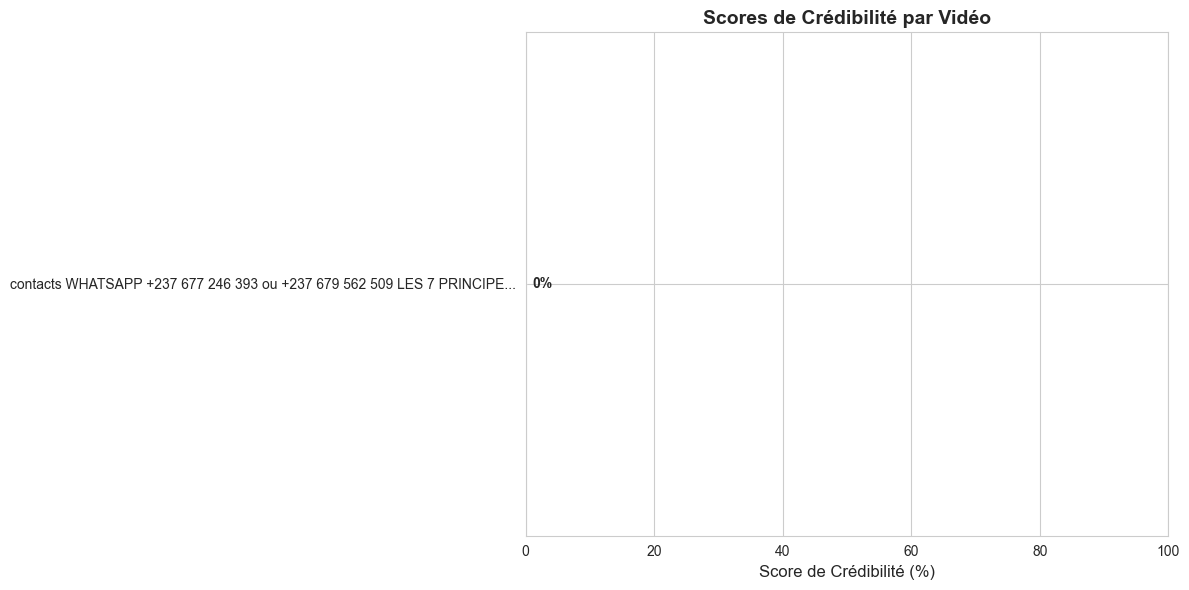

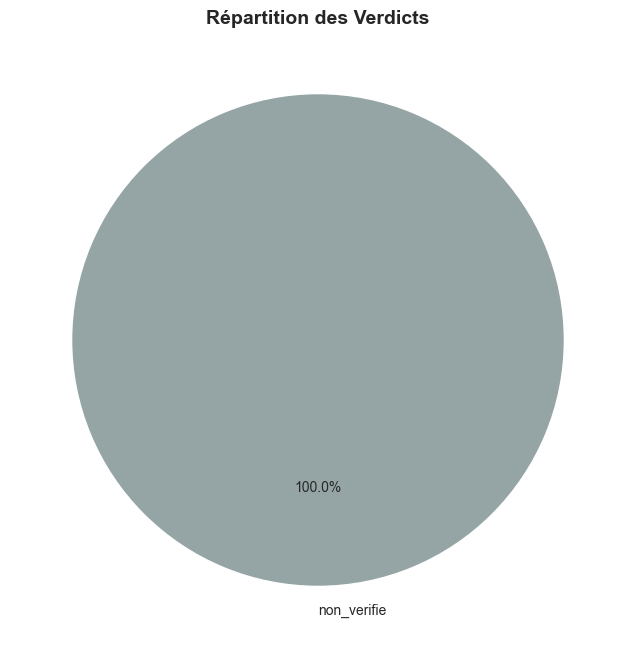

/Users/tetsa/Systems/system2/AI/projects/66.info.checker/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


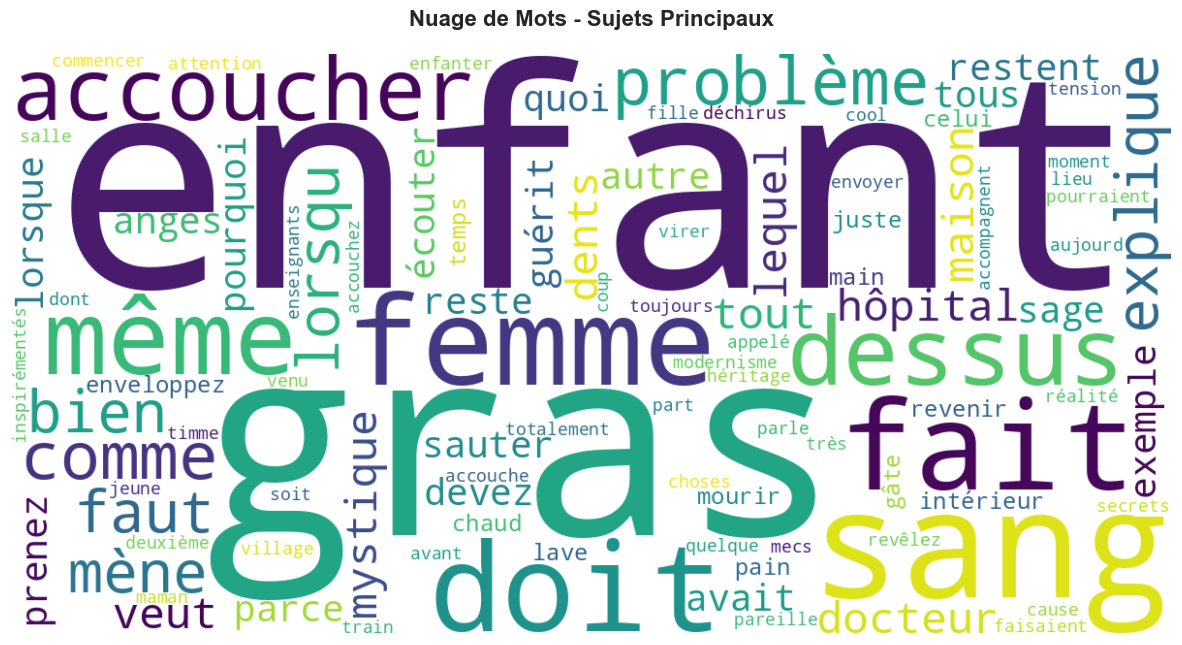

✅ Visualisations générées


In [15]:
import matplotlib.pyplot as plt

visualizer = ResultVisualizer()

print("📊 Génération des visualisations...")
fig1 = visualizer.create_credibility_chart(results['videos'])
plt.show()

fig2 = visualizer.create_verdict_pie(results['videos'])
plt.show()

all_transcriptions = [v['transcription']['text'] for v in results['videos']]
fig3 = visualizer.create_wordcloud(all_transcriptions)
plt.show()

fig4 = visualizer.create_timeline_chart(results['videos'])
if fig4:
    plt.show()

print("✅ Visualisations générées")


## 10. Sauvegarde des Résultats


In [16]:
storage = ResultStorage()

filename_prefix = f"{username if analysis_mode == 'user' else 'video'}"
saved_files = storage.save_results(results, filename_prefix=filename_prefix)

print(f"✅ Résultats sauvegardés:")
print(f"   JSON: {saved_files['json']}")
print(f"   Markdown: {saved_files['markdown']}")


✅ Résultats sauvegardés:
   JSON: results/video_20251122_121952.json
   Markdown: results/video_20251122_121952.md


## 11. Tableau de Bord Interactif


In [ ]:
dashboard = visualizer.create_interactive_dashboard(results['videos'])
dashboard.show()

dashboard_path = Config.OUTPUT_DIR / f"dashboard_{datetime.now().strftime('%Y%m%d_%H%M%S')}.html"
dashboard.write_html(str(dashboard_path))
print(f"✅ Tableau de bord sauvegardé: {dashboard_path}")
